In [2]:
!pip install torch-optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.4 MB/s eta 0:00:00


In [17]:
import torch
import torch_optimizer as optim
import torch.fft
import torch.nn as nn
from torch.nn import functional as F
import torch.backends.cudnn as cudnn
from collections import OrderedDict
import numpy as np
import random
import argparse
import os
import matplotlib.pyplot as plt


In [4]:
"""Optimizer choices."""

def choose_optimizer(optimizer_name: str, *params):
    if optimizer_name == 'LBFGS':
        return LBFGS(*params)
    elif optimizer_name == 'AdaHessian':
        return AdaHessian(*params)
    elif optimizer_name == 'Shampoo':
        return Shampoo(*params)
    elif optimizer_name == 'Yogi':
        return Yogi(*params)
    elif optimizer_name == 'Apollo':
        return Apollo(*params)
    elif optimizer_name == 'Adam':
        return Adam(*params)
    elif optimizer_name == 'SGD':
        return SGD(*params)

def LBFGS(model_param,
        lr=1.0,
        max_iter=100000,
        max_eval=None,
        history_size=50,
        tolerance_grad=1e-7,
        tolerance_change=1e-7,
        line_search_fn="strong_wolfe"):

    optimizer = torch.optim.LBFGS(
        model_param,
        lr=lr,
        max_iter=max_iter,
        max_eval=max_eval,
        history_size=history_size,
        tolerance_grad=tolerance_grad,
        tolerance_change=tolerance_change,
        line_search_fn=line_search_fn
        )

    return optimizer

def Adam(model_param, lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False):

    optimizer = torch.optim.Adam(
                model_param,
                lr=lr,
                betas=betas,
                eps=eps,
                weight_decay=weight_decay,
                amsgrad=amsgrad
    )
    return optimizer

def SGD(model_param, lr=1e-4, momentum=0.9, dampening=0, weight_decay=0, nesterov=False):

    optimizer = torch.optim.SGD(
                model_param,
                lr=lr,
                momentum=momentum,
                dampening=dampening,
                weight_decay=weight_decay,
                nesterov=False
    )

    return optimizer

def AdaHessian(model_param, lr=1.0, betas=(0.9, 0.999),
                eps=1e-4, weight_decay=0.0, hessian_power=0.5):
    """
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 0.15)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-4)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        hessian_power (float, optional): Hessian power (default: 0.5)
    """

    optimizer = Adahessian(model_param,
                            lr=lr,
                            betas=betas,
                            eps=eps,
                            weight_decay=weight_decay,
                            hessian_power=hessian_power,
                            single_gpu=False)

    return optimizer

def Shampoo(model_param, lr=1e-1, momentum=0.0, weight_decay=0.0,
            epsilon=1e-4, update_freq=1):
    """
    Args:
        params: params of model
        lr: learning rate
        momentum: momentum factor
        weight_decay: weight decay (L2 penalty)
        epsilon: epsilon added to each mat_gbar_j for numerical stability
        update_freq: update frequency to compute inverse
    """
    optimizer = optim.Shampoo(model_param,
                            lr=lr,
                            momentum=momentum,
                            weight_decay=weight_decay,
                            epsilon=epsilon,
                            update_freq=update_freq)

    return optimizer

def Yogi(model_param, lr=1e-2, betas=(0.9, 0.999), eps=1e-3, initial_accumulator=1e-6,
        weight_decay=0):

    optimizer = optim.Yogi(model_param,
                            lr=lr,
                            betas=betas,
                            eps=eps,
                            initial_accumulator=initial_accumulator,
                            weight_decay=weight_decay)

    return optimizer

def Apollo(model_param, lr=1e-2, beta=0.9, eps=1e-4, warmup=5, init_lr=0.01, weight_decay=0):
    """Apollo already includes warmup!

    Arguments:
        params: iterable of parameters to optimize or dicts defining
            parameter groups
        lr: learning rate (default: 1e-2)
        beta: coefficient used for computing
            running averages of gradient (default: 0.9)
        eps: term added to the denominator to improve
            numerical stability (default: 1e-4)
        warmup: number of warmup steps (default: 5)
        init_lr: initial learning rate for warmup (default: 0.01)
        weight_decay: weight decay (L2 penalty) (default: 0)
    """

    optimizer = optim.Apollo(model_param,
                            lr=lr,
                            beta=beta,
                            eps=eps,
                            warmup=warmup,
                            init_lr=init_lr,
                            weight_decay=weight_decay)
    return optimizer

In [6]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def sample_random(X_all, N):
    """Given an array of (x,t) points, sample N points from this."""
    set_seed(0) # this can be fixed for all N_f

    idx = np.random.choice(X_all.shape[0], N, replace=False)
    X_sampled = X_all[idx, :]

    return X_sampled

def set_activation(activation):
    if activation == 'identity':
        return nn.Identity()
    elif activation == 'tanh':
        return nn.Tanh()
    elif activation == 'relu':
        return  nn.ReLU()
    elif activation == 'gelu':
        return nn.GELU()
    else:
        print("WARNING: unknown activation function!")
        return -1

In [9]:
"""Pick a system to study here for Poisson's/diffusion."""
def function(u0: str):
    """Initial condition, string --> function."""

    if u0 == 'sin(x)':
        u0 = lambda x: np.sin(x)
    elif u0 == 'sin(pix)':
        u0 = lambda x: np.sin(np.pi*x)
    elif u0 == 'sin^2(x)':
        u0 = lambda x: np.sin(x)**2
    elif u0 == 'sin(x)cos(x)':
        u0 = lambda x: np.sin(x)*np.cos(x)
    elif u0 == '0.1sin(x)':
        u0 = lambda x: 0.1*np.sin(x)
    elif u0 == '0.5sin(x)':
        u0 = lambda x: 0.5*np.sin(x)
    elif u0 == '10sin(x)':
        u0 = lambda x: 10*np.sin(x)
    elif u0 == '50sin(x)':
        u0 = lambda x: 50*np.sin(x)
    elif u0 == '1+sin(x)':
        u0 = lambda x: 1 + np.sin(x)
    elif u0 == '2+sin(x)':
        u0 = lambda x: 2 + np.sin(x)
    elif u0 == '6+sin(x)':
        u0 = lambda x: 6 + np.sin(x)
    elif u0 == '10+sin(x)':
        u0 = lambda x: 10 + np.sin(x)
    elif u0 == 'sin(2x)':
        u0 = lambda x: np.sin(2*x)
    elif u0 == 'tanh(x)':
        u0 = lambda x: np.tanh(x)
    elif u0 == '2x':
        u0 = lambda x: 2*x
    elif u0 == 'x^2':
        u0 = lambda x: x**2
    elif u0 == 'gauss':
        x0 = np.pi
        sigma = np.pi/4
        u0 = lambda x: np.exp(-np.power((x - x0)/sigma, 2.)/2.)
    return u0

def reaction(u, rho, dt):
    """ du/dt = rho*u*(1-u)
    """
    factor_1 = u * np.exp(rho * dt)
    factor_2 = (1 - u)
    u = factor_1 / (factor_2 + factor_1)
    return u

def diffusion(u, nu, dt, IKX2):
    """ du/dt = nu*d2u/dx2
    """
    factor = np.exp(nu * IKX2 * dt)
    u_hat = np.fft.fft(u)
    u_hat *= factor
    u = np.real(np.fft.ifft(u_hat))
    return u

def reaction_solution(u0: str, rho, nx=256, nt=100):
    L = 2*np.pi
    T = 1
    dx = L/nx
    dt = T/nt
    x = np.arange(0, 2*np.pi, dx)
    t = np.linspace(0, T, nt).reshape(-1, 1)
    X, T = np.meshgrid(x, t)

    # call u0 this way so array is (n, ), so each row of u should also be (n, )
    u0 = function(u0)
    u0 = u0(x)

    u = reaction(u0, rho, T)

    u = u.flatten()
    return u

def reaction_diffusion_discrete_solution(u0 : str, nu, rho, nx = 256, nt = 100):
    """ Computes the discrete solution of the reaction-diffusion PDE using
        pseudo-spectral operator splitting.
    Args:
        u0: initial condition
        nu: diffusion coefficient
        rho: reaction coefficient
        nx: size of x-tgrid
        nt: number of points in the t grid
    Returns:
        u: solution
    """
    L = 2*np.pi
    T = 1
    dx = L/nx
    dt = T/nt
    x = np.arange(0, L, dx) # not inclusive of the last point
    t = np.linspace(0, T, nt).reshape(-1, 1)
    X, T = np.meshgrid(x, t)
    u = np.zeros((nx, nt))

    IKX_pos = 1j * np.arange(0, nx/2+1, 1)
    IKX_neg = 1j * np.arange(-nx/2+1, 0, 1)
    IKX = np.concatenate((IKX_pos, IKX_neg))
    IKX2 = IKX * IKX

    # call u0 this way so array is (n, ), so each row of u should also be (n, )
    u0 = function(u0)
    u0 = u0(x)

    u[:,0] = u0
    u_ = u0
    for i in range(nt-1):
        u_ = reaction(u_, rho, dt)
        u_ = diffusion(u_, nu, dt, IKX2)
        u[:,i+1] = u_

    u = u.T
    u = u.flatten()
    return u

def convection_diffusion(u0: str, nu, beta, source=0, xgrid=256, nt=100):
    """Calculate the u solution for convection/diffusion, assuming PBCs.
    Args:
        u0: Initial condition
        nu: viscosity coefficient
        beta: wavespeed coefficient
        source: q (forcing term), option to have this be a constant
        xgrid: size of the x grid
    Returns:
        u_vals: solution
    """

    N = xgrid
    h = 2 * np.pi / N
    x = np.arange(0, 2*np.pi, h) # not inclusive of the last point
    t = np.linspace(0, 1, nt).reshape(-1, 1)
    X, T = np.meshgrid(x, t)

    # call u0 this way so array is (n, ), so each row of u should also be (n, )
    u0 = function(u0)
    u0 = u0(x)

    G = (np.copy(u0)*0)+source # G is the same size as u0

    IKX_pos =1j * np.arange(0, N/2+1, 1)
    IKX_neg = 1j * np.arange(-N/2+1, 0, 1)
    IKX = np.concatenate((IKX_pos, IKX_neg))
    IKX2 = IKX * IKX

    uhat0 = np.fft.fft(u0)
    nu_factor = np.exp(nu * IKX2 * T - beta * IKX * T)
    A = uhat0 - np.fft.fft(G)*0 # at t=0, second term goes away
    uhat = A*nu_factor + np.fft.fft(G)*T # for constant, fft(p) dt = fft(p)*T
    u = np.real(np.fft.ifft(uhat))

    u_vals = u.flatten()
    return u_vals

In [10]:
"""
Visualize outputs.
"""
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

def exact_u(Exact, x, t, nu, beta, rho, layers, N_f, L, source, u0_str, system, path):
    """Visualize exact solution."""
    fig = plt.figure(figsize=(9, 5))
    ax = fig.add_subplot(111)

    h = ax.imshow(Exact.T, interpolation='nearest', cmap='rainbow',
                  extent=[t.min(), t.max(), x.min(), x.max()],
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.10)
    cbar = fig.colorbar(h, cax=cax)
    cbar.ax.tick_params(labelsize=15)

    line = np.linspace(x.min(), x.max(), 2)[:,None]

    ax.set_xlabel('t', fontweight='bold', size=30)
    ax.set_ylabel('x', fontweight='bold', size=30)
    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.9, -0.05),
        ncol=5,
        frameon=False,
        prop={'size': 15}
    )

    ax.tick_params(labelsize=15)

    plt.savefig(f"{path}/exactu_{system}_nu{nu}_beta{beta}_rho{rho}_Nf{N_f}_{layers}_L{L}_source{source}_{u0_str}.pdf")
    plt.close()

    return None

def u_diff(Exact, U_pred, x, t, nu, beta, rho, seed, layers, N_f, L, source, lr, u0_str, system, path, relative_error = False):
    """Visualize abs(u_pred - u_exact)."""

    fig = plt.figure(figsize=(9, 5))
    ax = fig.add_subplot(111)

    if relative_error:
        h = ax.imshow(np.abs(Exact.T - U_pred.T)/np.abs(Exact.T), interpolation='nearest', cmap='binary',
                    extent=[t.min(), t.max(), x.min(), x.max()],
                    origin='lower', aspect='auto')
    else:
        h = ax.imshow(np.abs(Exact.T - U_pred.T), interpolation='nearest', cmap='binary',
                    extent=[t.min(), t.max(), x.min(), x.max()],
                    origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.10)
    cbar = fig.colorbar(h, cax=cax)
    cbar.ax.tick_params(labelsize=15)

    line = np.linspace(x.min(), x.max(), 2)[:,None]

    ax.set_xlabel('t', fontweight='bold', size=30)
    ax.set_ylabel('x', fontweight='bold', size=30)

    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.9, -0.05),
        ncol=5,
        frameon=False,
        prop={'size': 15}
    )

    ax.tick_params(labelsize=15)

    plt.savefig(f"{path}/udiff_{system}_nu{nu}_beta{beta}_rho{rho}_Nf{N_f}_{layers}_L{L}_seed{seed}_source{source}_{u0_str}_lr{lr}.pdf")

    return None

def u_predict(u_vals, U_pred, x, t, nu, beta, rho, seed, layers, N_f, L, source, lr, u0_str, system, path):
    """Visualize u_predicted."""

    fig = plt.figure(figsize=(9, 5))
    ax = fig.add_subplot(111)

    # colorbar for prediction: set min/max to ground truth solution.
    h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow',
                  extent=[t.min(), t.max(), x.min(), x.max()],
                  origin='lower', aspect='auto', vmin=u_vals.min(0), vmax=u_vals.max(0))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.10)
    cbar = fig.colorbar(h, cax=cax)
    cbar.ax.tick_params(labelsize=15)

    line = np.linspace(x.min(), x.max(), 2)[:,None]

    ax.set_xlabel('t', fontweight='bold', size=30)
    ax.set_ylabel('x', fontweight='bold', size=30)

    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.9, -0.05),
        ncol=5,
        frameon=False,
        prop={'size': 15}
    )

    ax.tick_params(labelsize=15)

    plt.savefig(f"{path}/upredicted_{system}_nu{nu}_beta{beta}_rho{rho}_Nf{N_f}_{layers}_L{L}_seed{seed}_source{source}_{u0_str}_lr{lr}.pdf")

    plt.close()
    return None

In [14]:
# CUDA support
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cpu')

In [15]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers, activation, use_batch_norm=False, use_instance_norm=False):
        super(DNN, self).__init__()

        # parameters
        self.depth = len(layers) - 1

        if activation == 'identity':
            self.activation = torch.nn.Identity
        elif activation == 'tanh':
            self.activation = torch.nn.Tanh
        elif activation == 'relu':
            self.activation = torch.nn.ReLU
        elif activation == 'gelu':
            self.activation = torch.nn.GELU
        elif activation == 'sin':
            self.activation = Sine
        self.use_batch_norm = use_batch_norm
        self.use_instance_norm = use_instance_norm

        layer_list = list()
        for i in range(self.depth - 1):
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )

            if self.use_batch_norm:
                layer_list.append(('batchnorm_%d' % i, torch.nn.BatchNorm1d(num_features=layers[i+1])))
            if self.use_instance_norm:
                layer_list.append(('instancenorm_%d' % i, torch.nn.InstanceNorm1d(num_features=layers[i+1])))

            layer_list.append(('activation_%d' % i, self.activation()))

        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)

        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

class PhysicsInformedNN_pbc():
    """PINNs (convection/diffusion/reaction) for periodic boundary conditions."""
    def __init__(self, system, X_u_train, u_train, X_f_train, bc_lb, bc_ub, layers, G, nu, beta, rho, optimizer_name, lr,
        net, L=1, activation='tanh', loss_style='mean'):

        self.system = system

        self.x_u = torch.tensor(X_u_train[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u_train[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f_train[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f_train[:, 1:2], requires_grad=True).float().to(device)
        self.x_bc_lb = torch.tensor(bc_lb[:, 0:1], requires_grad=True).float().to(device)
        self.t_bc_lb = torch.tensor(bc_lb[:, 1:2], requires_grad=True).float().to(device)
        self.x_bc_ub = torch.tensor(bc_ub[:, 0:1], requires_grad=True).float().to(device)
        self.t_bc_ub = torch.tensor(bc_ub[:, 1:2], requires_grad=True).float().to(device)
        self.net = net

        if self.net == 'DNN':
            self.dnn = DNN(layers, activation).to(device)
        else: # "pretrained" can be included in model path
            # the dnn is within the PINNs class
            self.dnn = torch.load(net).dnn

        self.u = torch.tensor(u_train, requires_grad=True).float().to(device)
        self.layers = layers
        self.nu = nu
        self.beta = beta
        self.rho = rho

        self.G = torch.tensor(G, requires_grad=True).float().to(device)
        self.G = self.G.reshape(-1, 1)

        self.L = L

        self.lr = lr
        self.optimizer_name = optimizer_name

        self.optimizer = choose_optimizer(self.optimizer_name, self.dnn.parameters(), self.lr)

        self.loss_style = loss_style

        self.iter = 0

    def net_u(self, x, t):
        """The standard DNN that takes (x,t) --> u."""
        u = self.dnn(torch.cat([x, t], dim=1))
        return u

    def net_f(self, x, t):
        """ Autograd for calculating the residual for different systems."""
        u = self.net_u(x, t)

        u_t = torch.autograd.grad(
            u, t,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_xx = torch.autograd.grad(
            u_x, x,
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
            )[0]

        if 'convection' in self.system or 'diffusion' in self.system:
            f = u_t - self.nu*u_xx + self.beta*u_x - self.G
        elif 'rd' in self.system:
            f = u_t - self.nu*u_xx - self.rho*u + self.rho*u**2
        elif 'reaction' in self.system:
            f = u_t - self.rho*u + self.rho*u**2
        return f

    def net_b_derivatives(self, u_lb, u_ub, x_bc_lb, x_bc_ub):
        """For taking BC derivatives."""

        u_lb_x = torch.autograd.grad(
            u_lb, x_bc_lb,
            grad_outputs=torch.ones_like(u_lb),
            retain_graph=True,
            create_graph=True
            )[0]

        u_ub_x = torch.autograd.grad(
            u_ub, x_bc_ub,
            grad_outputs=torch.ones_like(u_ub),
            retain_graph=True,
            create_graph=True
            )[0]

        return u_lb_x, u_ub_x

    def loss_pinn(self, verbose=True):
        """ Loss function. """
        if torch.is_grad_enabled():
            self.optimizer.zero_grad()
        u_pred = self.net_u(self.x_u, self.t_u)
        u_pred_lb = self.net_u(self.x_bc_lb, self.t_bc_lb)
        u_pred_ub = self.net_u(self.x_bc_ub, self.t_bc_ub)
        if self.nu != 0:
            u_pred_lb_x, u_pred_ub_x = self.net_b_derivatives(u_pred_lb, u_pred_ub, self.x_bc_lb, self.x_bc_ub)
        f_pred = self.net_f(self.x_f, self.t_f)

        if self.loss_style == 'mean':
            loss_u = torch.mean((self.u - u_pred) ** 2)
            loss_b = torch.mean((u_pred_lb - u_pred_ub) ** 2)
            if self.nu != 0:
                loss_b += torch.mean((u_pred_lb_x - u_pred_ub_x) ** 2)
            loss_f = torch.mean(f_pred ** 2)
        elif self.loss_style == 'sum':
            loss_u = torch.sum((self.u - u_pred) ** 2)
            loss_b = torch.sum((u_pred_lb - u_pred_ub) ** 2)
            if self.nu != 0:
                loss_b += torch.sum((u_pred_lb_x - u_pred_ub_x) ** 2)
            loss_f = torch.sum(f_pred ** 2)

        loss = loss_u + loss_b + self.L*loss_f

        if loss.requires_grad:
            loss.backward()

        grad_norm = 0
        for p in self.dnn.parameters():
            param_norm = p.grad.detach().data.norm(2)
            grad_norm += param_norm.item() ** 2
        grad_norm = grad_norm ** 0.5

        if verbose:
            if self.iter % 100 == 0:
                print(
                    'epoch %d, gradient: %.5e, loss: %.5e, loss_u: %.5e, loss_b: %.5e, loss_f: %.5e' % (self.iter, grad_norm, loss.item(), loss_u.item(), loss_b.item(), loss_f.item())
                )
            self.iter += 1

        return loss

    def train(self):
        self.dnn.train()
        self.optimizer.step(self.loss_pinn)

    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        u = u.detach().cpu().numpy()

        return u

In [23]:
################
# Arguments
################

system = 'convection' # system to study
seed = 42 # random seed
N_f = 100 # num of collocation points to sample
optimizer_name = 'LBFGS' # optimizer
lr = 0.01 # learning rate
L = 1.0 # multiplier on loss func
xgrid = 256 # num of points in the xgrid
nt = 100 # num of points in tgrid
nu = 1.0 # nu value that scales the d^2u/dx^2 term. 0 if only doing advection
rho = 1.0 # reaction coefficient for u*(1-d) term
beta = 1.0 # beta value that scales the du/dx term. 0 if only doing diffusion
u0_str = 'sin(x)' # str argument for initial condition if no forcing term
source = 0 # if there's a source term, define it here. For now, just constant force terms
layers = '50, 50, 50, 50, 1' # dims/layers of the NN, minus the first layer
net = 'DNN' # net architecture
activation = 'tanh' # activation to use
loss_style = 'mean' # loss (MSE vs summing)
visualize = True # visualize the solution
save_model = True # save the model


In [24]:
if system == 'diffusion': # just diffusion
    beta = 0.0
    rho = 0.0
elif system == 'convection':
    nu = 0.0
    rho = 0.0
elif system == 'rd': # reaction-diffusion
    beta = 0.0
elif system == 'reaction':
    nu = 0.0
    beta = 0.0

print('nu', nu, 'beta', beta, 'rho', rho)

nu 0.0 beta 1.0 rho 0.0


In [25]:
# parse the layers list here
orig_layers = layers
layers = [int(item) for item in layers.split(',')]

In [26]:
############################
# Process data
############################

x = np.linspace(0, 2*np.pi, xgrid, endpoint=False).reshape(-1, 1) # not inclusive
t = np.linspace(0, 1, nt).reshape(-1, 1)
X, T = np.meshgrid(x, t) # all the X grid points T times, all the T grid points X times
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None])) # all the x,t "test" data

# remove initial and boundary data from X_star
t_noinitial = t[1:]
# remove boundary at x=0
x_noboundary = x[1:]
X_noboundary, T_noinitial = np.meshgrid(x_noboundary, t_noinitial)
X_star_noinitial_noboundary = np.hstack((X_noboundary.flatten()[:, None], T_noinitial.flatten()[:, None]))

# sample collocation points only from the interior (where the PDE is enforced)
X_f_train = sample_random(X_star_noinitial_noboundary, N_f)

if 'convection' in system or 'diffusion' in system:
    u_vals = convection_diffusion(u0_str, nu, beta, source, xgrid, nt)
    G = np.full(X_f_train.shape[0], float(source))
elif 'rd' in system:
    u_vals = reaction_diffusion_discrete_solution(u0_str, nu, rho, xgrid, nt)
    G = np.full(X_f_train.shape[0], float(source))
elif 'reaction' in system:
    u_vals = reaction_solution(u0_str, rho, xgrid, nt)
    G = np.full(X_f_train.shape[0], float(source))
else:
    print("WARNING: System is not specified.")

u_star = u_vals.reshape(-1, 1) # Exact solution reshaped into (n, 1)
Exact = u_star.reshape(len(t), len(x)) # Exact on the (x,t) grid

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) # initial condition, from x = [-end, +end] and t=0
uu1 = Exact[0:1,:].T # u(x, t) at t=0
bc_lb = np.hstack((X[:,0:1], T[:,0:1])) # boundary condition at x = 0, and t = [0, 1]
uu2 = Exact[:,0:1] # u(-end, t)

# generate the other BC, now at x=2pi
t = np.linspace(0, 1, nt).reshape(-1, 1)
x_bc_ub = np.array([2*np.pi]*t.shape[0]).reshape(-1, 1)
bc_ub = np.hstack((x_bc_ub, t))

u_train = uu1 # just the initial condition
X_u_train = xx1 # (x,t) for initial condition

layers.insert(0, X_u_train.shape[-1])

epoch 0, gradient: 9.04166e-01, loss: 5.28691e-01, loss_u: 5.23992e-01, loss_b: 4.56242e-03, loss_f: 1.37105e-04
epoch 100, gradient: 2.48973e-01, loss: 8.33250e-02, loss_u: 6.17670e-02, loss_b: 1.33256e-02, loss_f: 8.23246e-03
epoch 200, gradient: 2.64483e-01, loss: 1.82265e-02, loss_u: 9.04354e-03, loss_b: 2.10681e-03, loss_f: 7.07620e-03
epoch 300, gradient: 4.14211e-01, loss: 4.45968e-03, loss_u: 1.15708e-03, loss_b: 5.42300e-04, loss_f: 2.76030e-03
epoch 400, gradient: 2.99731e-02, loss: 1.65343e-03, loss_u: 3.86048e-04, loss_b: 1.22422e-04, loss_f: 1.14496e-03
epoch 500, gradient: 8.65843e-02, loss: 6.04803e-04, loss_u: 2.24241e-04, loss_b: 1.51401e-05, loss_f: 3.65422e-04
epoch 600, gradient: 7.33145e-02, loss: 3.38162e-04, loss_u: 1.40724e-04, loss_b: 3.52849e-06, loss_f: 1.93909e-04
epoch 700, gradient: 1.98157e-02, loss: 2.11978e-04, loss_u: 1.17186e-04, loss_b: 1.38686e-05, loss_f: 8.09232e-05
epoch 800, gradient: 2.89084e-02, loss: 1.27970e-04, loss_u: 7.19235e-05, loss_b: 

Error u rel: 1.124668e-02
Error u abs: 6.985581e-03
Error u linf: 1.590367e-02


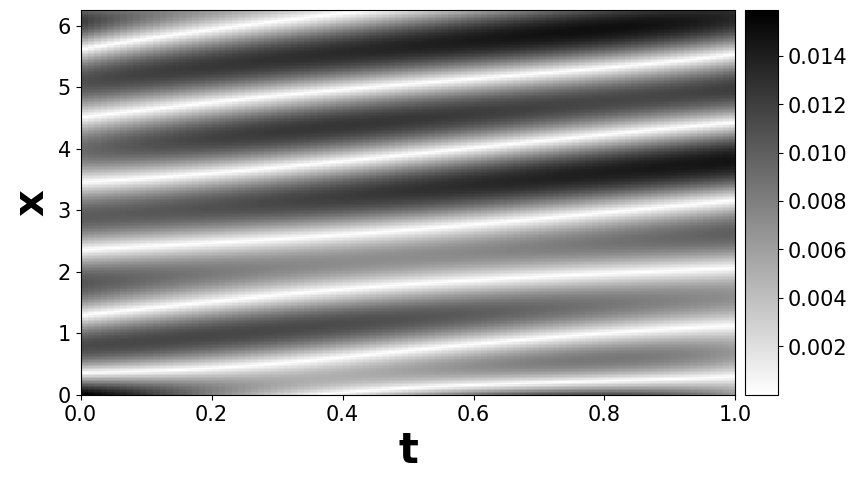

In [27]:
"""Run PINNs for convection/reaction/reaction-diffusion with periodic boundary conditions."""

############################
# Train the model
############################

set_seed(seed) # for weight initialization

model = PhysicsInformedNN_pbc(system, X_u_train, u_train, X_f_train, bc_lb, bc_ub, layers, G, nu, beta, rho,
                              optimizer_name, lr, net, L, activation, loss_style)
model.train()

u_pred = model.predict(X_star)

error_u_relative = np.linalg.norm(u_star-u_pred, 2)/np.linalg.norm(u_star, 2)
error_u_abs = np.mean(np.abs(u_star - u_pred))
error_u_linf = np.linalg.norm(u_star - u_pred, np.inf)/np.linalg.norm(u_star, np.inf)

print('Error u rel: %e' % (error_u_relative))
print('Error u abs: %e' % (error_u_abs))
print('Error u linf: %e' % (error_u_linf))

if visualize:
    path = f"heatmap_results/{system}"
    if not os.path.exists(path):
        os.makedirs(path)
    u_pred = u_pred.reshape(len(t), len(x))
    exact_u(Exact, x, t, nu, beta, rho, orig_layers, N_f, L, source, u0_str, system, path=path)
    u_diff(Exact, u_pred, x, t, nu, beta, rho, seed, orig_layers, N_f, L, source, lr, u0_str, system, path=path)
    u_predict(u_vals, u_pred, x, t, nu, beta, rho, seed, orig_layers, N_f, L, source, lr, u0_str, system, path=path)

if save_model: # whether or not to save the model
    path = "saved_models"
    if not os.path.exists(path):
        os.makedirs(path)
    if 'pretrained' not in net: # only save new models
        torch.save(model, f"saved_models/pretrained_{system}_u0{u0_str}_nu{nu}_beta{beta}_rho{rho}_Nf{N_f}_{layers}_L{L}_source{source}_seed{seed}.pt")